# Project 1: Preparing an image dataset for model training

**Goal:**

- Implement a [map-style Dataset class](https://pytorch.org/docs/stable/data.html#map-style-datasets).
    - map-style dataset class: when accessed with dataset[idx], could read the idx-th image and its corresponding label from a folder on the disk
- Implement a [data loader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) that directly feeds data into model training.
- Quality check your data, served through dataset class.

**Acceptance criteria:**

- The Dataset class should implement `__getitem__`  and `__len__` methods, where `__getitem__` should return a training example, which is a tuple of (image, label).
- The data loader should be iterable and returns batches of examples.
- In a notebook, present example images, labels and ensure correct shapes by visual inspection.

## Step 1: Create a Dataset class

One of the first things you may need to do in a practical project is to create a custom dataset class. As a start, let us use [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), a dataseet with 80 million labeled images, as an example to create one. First, we need to download the data:


In [ ]:
# Please makse sure to remove the exclamation mark if you run the commands in the terminal.
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz

--2022-08-11 00:54:41--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  45.0MB/s    in 4.0s    

2022-08-11 00:54:46 (40.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



Inspect the downloaded raw data and folder structure:

In [ ]:
!ls -lht cifar-10-batches-py/

total 178M
-rw-r--r-- 1 2156 1103  88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 30M Mar 31  2009 test_batch


The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object.

Loaded using the `unpickle` method provided below, each of the batch files contains a python dictionary with the following elements:

*data* -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

*labels* -- a list of 10000 numbers in the range 0-9. Each number maps to a class label. For information about the 10 classes, please refer to the [CIFAR-10 website](https://www.cs.toronto.edu/~kriz/cifar.html).

**Your task**: Fill in the missing code in the next cell, so that it can pass the test that follows.

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
data: <class 'numpy.ndarray'> (10000, 3072)
labels: <class 'list'> 10000


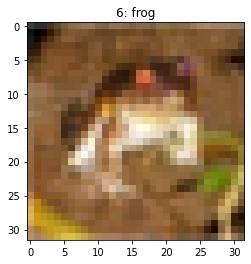

In [ ]:
import pickle


CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    # The keys of this dic: [b'batch_label', b'labels', b'data', b'filenames']
    return dict


def reshape_numpy_image(one_numpy_image):
    shape_with_channels_first = (3, 32, 32)  # (channels, height, width), channels first
    shape_with_channels_last = (32, 32, 3)  # (height, width, channels), channels last
    # TODO: in the next line, should we use shape_with_channels_first or shape_with_channels_last?
    #   It depends on how the numpy array in the raw data is stored. It is hard to know which
    #   way is correct without trying both and visualizing.
    return one_numpy_image.reshape(*shape_with_channels_first)#**in the  colab you put shape_with_channels_last


def print_and_visualize_data():
  data_dict = unpickle("cifar-10-batches-py/data_batch_1")
  print(data_dict.keys())
  data = data_dict[b"data"]
  labels = data_dict[b"labels"]
  print("data:", type(data), data.shape)
  print("labels:", type(labels), len(labels))


  from matplotlib import pyplot as plt
  one_image = data[0, :]
  reshaped_image = reshape_numpy_image(one_image)

  # imshow() requires the image to be in "channels last" format
  # So if the image is "channels first", transpose it.
  if reshaped_image.shape[0] == 3:
    reshaped_image = reshaped_image.transpose(1, 2, 0)

  plt.imshow(reshaped_image)
  _ = plt.title(f"{labels[0]}: {CLASSES[labels[0]]}")


# Uncomment the following line to visualize data.
print_and_visualize_data()

In [ ]:
import numpy as np
from typing import Tuple


class CustomDataset:
    def __init__(self, data_dir="cifar-10-batches-py", train=True):
        # TODO: if train is True, load the training data (data_batch_1 through 5), otherwise load the validation data (test_data_batch).
        if train:
          for i in range(1, 6):
            data_dict = unpickle(f"{data_dir}/data_batch_{i}")
            if i == 1:
              self.images = data_dict[b"data"]
              self.labels = data_dict[b"labels"]
            else:
              self.images = np.concatenate([self.images, data_dict[b"data"]], axis=0)
              self.labels = self.labels + data_dict[b"labels"]
        else:
          data_dict = unpickle("{data_dir}/test_batch")
          self.labels = data_dict[b"labels"]
          self.images = data_dict[b"data"]

    def __getitem__(self, index) -> Tuple[np.array, np.array]:
        image = self.images[index]
        image = reshape_numpy_image(image)
        label = self.labels[index]
        return image, label
    
    def __len__(self) -> int:
        return len(self.labels)

In [ ]:
# This is the test code for the class CustomDataset.

def test_custom_dataset():
    ds = CustomDataset(train=True)
    print(f"Dataset has {len(ds)} examples")
    assert len(ds) == 50000, f"Expect the training set to have 50000 examples."
    ds = CustomDataset(train=False)
    assert len(ds) == 10000, f"Expect the validation set to have 10000 examples."
    first_example = ds[0]
    print(f"The first example is a {type(first_example)} with {len(first_example)} elements")
    image, label = first_example
    print(f"The first example has an image with type {type(image)} and shape {image.shape} and label {label}")
    assert len(image.shape) == 3
    assert (label >= 0) and (label < 10), f"Label {label} is not in [0, 10)"
    print("Test passed!")

test_custom_dataset()

Dataset has 50000 examples
The first example is a <class 'tuple'> with 2 elements
The first example has an image of shape (32, 32, 3) and label 3
Test passed!


If the tests works, congratulations! You have completed the first step of the project. You have implemented a dataset class similar to `torchvision.datasets.CIFAR10`.


## Step 2: Visualize the image data

However, passing the unit tests may not be enough. The content of the image may not make sense even if the shape is correct, depending on how the reshaping of numpy arrays is done.

In the next cells, display several images from the dataset together with the label. Visually check the image and the label. A helper function is provided.

In [ ]:
from matplotlib import pyplot as plt

import numpy as np

def display_image_with_label(image: np.array, label: int):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

# TODO: add code to the next cells to display at least 2 images from CustomDataset.
# You can use one cell for each image.

Text(0.5, 1.0, '6: frog')

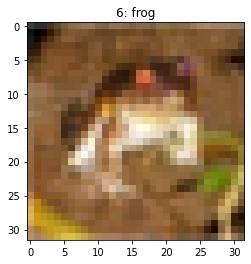

In [ ]:
# TODO: display the first image and label

ds = CustomDataset(train=True)
image, label = ds[0]
plt.imshow(image.transpose(1, 2, 0))
plt.title(f"{label}: {CLASSES[label]}")

Text(0.5, 1.0, '9: truck')

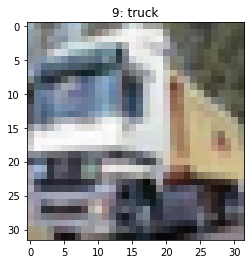

In [ ]:
# TODO: display the second image and label
image, label = ds[1]
plt.imshow(image.transpose(1, 2, 0))
plt.title(f"{label}: {CLASSES[label]}")


## Step 3: Create a data loader

A data loader is a class that can be used to load batches of data. It provides a way to iterate over the `Dataset`, returning a batch of data at each iteration.

For PyTorch, we strongly recommend using the [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class to load the data. It has a lot of built-in functionalities to handle efficient concurrent loading of data that you don't need to implement from scratch. In our experience, it is rarely needed to implement a custom version of `DataLoader`. Getting familar with how to use a PyTorch `DataLoader` is usually enough.

**Your task**: Fill in the missing code in the next cell, so that it can pass the test that follows.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

# TODO: fill in the code to create a data loader with a batch size of 16.
# data_loader = DataLoader(...)
data_loader = DataLoader(CustomDataset(train=False), batch_size=batch_size)

In [ ]:
def test_data_loader():
    for batch in data_loader:
        images, labels = batch
        assert images.shape[0] == batch_size, f"Expecting a batch of {batch_size} images"
        assert len(images.shape) == 4, f"shape is {images.shape} for the image batch"
        assert len(labels) == batch_size, f"Expecting a batch of {batch_size} labels"
        print("The test is passed!")
        break


test_data_loader()

The test is passed!


#### Display images in a grid using `matplotlib`

You can also display multiple images in one figure. This way you can visualize a batch of images easily. Below is a function to start with.

```
def show_images(images, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    plt.figure(figsize=(2 * ncols, 2 * nrows))
    for i in range(len(images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
```

torch.Size([16, 3, 32, 32]) <class 'torch.Tensor'>


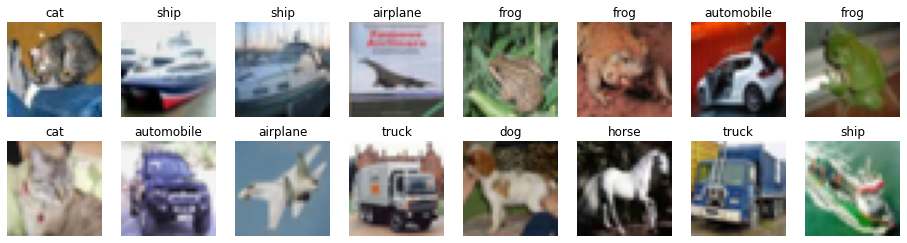

In [ ]:
def show_images(images, labels: list = None, ncols: int = 8):
    nrows = (len(images) + ncols - 1) // ncols
    plt.figure(figsize=(2 * ncols, 2 * nrows))
    for i in range(len(images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        if labels is not None:
          plt.title(labels[i])
        plt.axis('off')

batch = next(iter(data_loader))
images, labels = batch
print(images.shape, type(images))
label_texts = [CLASSES[l] for l in labels.numpy().tolist()]
images = [im.transpose(1, 2, 0) for im in images.numpy()]
show_images(images, label_texts)

## Step 4 (optional): Writing unit tests for your dataset class

To make sure your dataset is feeding the right data to the model, visualization is helpful, but unit tests can make certain checks more efficient.

You may have noticed, in previous steps unit tests such as `test_custom_dataset` are already used to check the correctness of your implementation.

The following types of unit tests can be written against a dataset class:

- Tests that check the functionality of the class (e.g. calling `len(dataset)` does not raise an error).
- Tests that check the type and shape of the data returned by the class.
- Tests that check the content of the data returned by the class.

Below is an example unit test that checks if the shape of the image is "channels-first" (3, height, width) rather than "channels-last" (height, width, 3). PyTorch expects the image to be in "channels-first" format, while Tensorflow expects it to be "channels-last".

**Your task**: Fill in the missing code in unit test. Make necesssary changes to your dataset class to pass the test. Can you think of other tests that can answer questions about the dataset? For example, can you write a test about the maximum pixel intensity of this dataset?



In [ ]:
# def test_custom_dataset_returns_images_with_channels_first():
#     """Check the shape of the image, especially the channels axis.
#     """
#     # TODO: fill in.
#     pass

def test_custom_dataset_returns_images_with_channels_first():
    """Check the shape of the image, especially the channels axis.
    """
    ds = CustomDataset(train=True)
    image, label = ds[0]
    assert image.shape[0] == 3

test_custom_dataset_returns_images_with_channels_first()

**Congratulations!** You have completed the first project of this course.

